In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

### Importation des données

In [40]:
os.chdir(r'C:\Documents\travail\LYON2\M2\deep_learning')

In [29]:
transform = transforms.Compose([transforms.Resize((150,150)), transforms.ToTensor()])

In [30]:
data_train = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\train_another',transform=transform)
data_test = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\test_another',transform=transform)
data_val = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\validation_another',transform=transform)

In [4]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32)

Pour le code suivant, nous avons utilisé celui présent sur ce site :
https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48    

### Base Model for image classification

In [19]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Architecture du CNN

Nous essayons de reproduire le modèle CNN de Cao et Choe afin de 
comparer les résultats

In [44]:
class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512), #car 4 maxpooling et 150/16 environs = 9 et on arrondi
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

### Hyperparameters, Model Training, And Evaluation

In [23]:
model = Net()
lr = 0.0001
epochs = 50
max_steps_per_epoch = 100
opt_func = torch.optim.RMSprop
max_validation_step = 50

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader, max_validation_step):
    model.eval()
    outputs = []
    for i, batch in enumerate(val_loader):
        if i >= max_validation_step:
            break
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func, max_steps_per_epoch=None):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        step = 0
        for batch in train_loader:
            if max_steps_per_epoch and step >= max_steps_per_epoch:
                break
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step += 1
            
        result = evaluate(model, val_loader, max_validation_step)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [27]:
res = fit(epochs, lr, model, train_loader, val_loader, opt_func, max_steps_per_epoch)

Epoch [0], train_loss: 0.5834, val_loss: 0.5393, val_acc: 0.7688
Epoch [1], train_loss: 0.5180, val_loss: 0.4730, val_acc: 0.8369
Epoch [2], train_loss: 0.4832, val_loss: 0.4520, val_acc: 0.8600
Epoch [3], train_loss: 0.4565, val_loss: 0.4273, val_acc: 0.8869
Epoch [4], train_loss: 0.4439, val_loss: 0.4636, val_acc: 0.8444
Epoch [5], train_loss: 0.4304, val_loss: 0.4322, val_acc: 0.8756
Epoch [6], train_loss: 0.4277, val_loss: 0.3997, val_acc: 0.9131
Epoch [7], train_loss: 0.4229, val_loss: 0.4327, val_acc: 0.8806
Epoch [8], train_loss: 0.4237, val_loss: 0.4224, val_acc: 0.8913
Epoch [9], train_loss: 0.4154, val_loss: 0.3923, val_acc: 0.9212
Epoch [10], train_loss: 0.4145, val_loss: 0.3835, val_acc: 0.9250
Epoch [11], train_loss: 0.4152, val_loss: 0.3937, val_acc: 0.9219
Epoch [12], train_loss: 0.4168, val_loss: 0.3731, val_acc: 0.9356
Epoch [13], train_loss: 0.4057, val_loss: 0.4231, val_acc: 0.8906
Epoch [14], train_loss: 0.4066, val_loss: 0.3823, val_acc: 0.9312
Epoch [15], train_lo

In [50]:
res

[{'val_loss': 0.5393309593200684,
  'val_acc': 0.768750011920929,
  'train_loss': 0.5834473967552185},
 {'val_loss': 0.4729901850223541,
  'val_acc': 0.8368750214576721,
  'train_loss': 0.5179715752601624},
 {'val_loss': 0.45197898149490356,
  'val_acc': 0.8600000143051147,
  'train_loss': 0.48323631286621094},
 {'val_loss': 0.4273059070110321,
  'val_acc': 0.8868749737739563,
  'train_loss': 0.4565161466598511},
 {'val_loss': 0.4635903239250183,
  'val_acc': 0.8443750143051147,
  'train_loss': 0.44393694400787354},
 {'val_loss': 0.432158887386322,
  'val_acc': 0.8756250143051147,
  'train_loss': 0.4304075241088867},
 {'val_loss': 0.3997455835342407,
  'val_acc': 0.9131249785423279,
  'train_loss': 0.42767494916915894},
 {'val_loss': 0.43273013830184937,
  'val_acc': 0.8806250095367432,
  'train_loss': 0.4228794574737549},
 {'val_loss': 0.42236122488975525,
  'val_acc': 0.8912500143051147,
  'train_loss': 0.4237128496170044},
 {'val_loss': 0.3923085331916809,
  'val_acc': 0.92124998569

In [37]:
cnn1 = pd.DataFrame(res)

In [42]:
cnn1.to_csv('cnn1.csv', sep='\t')

In [58]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

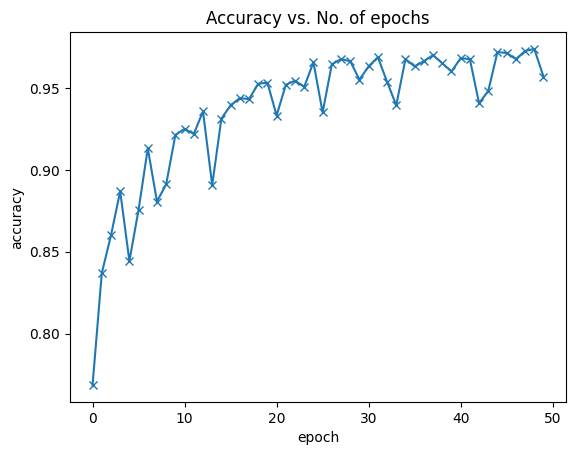

In [59]:
plot_accuracies(res)

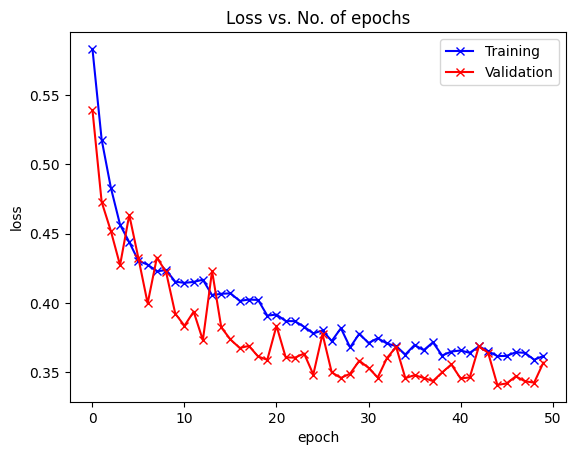

In [60]:
plot_losses(res)

### 2ème CNN

Nous essayons maitenant de reproduire le modèle CNN+DA+DO (Adam) de Cao et Choe afin de comparer les résultats

Augmentation des données

In [52]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=(0.8,1.2), shear=20),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()
])

data_train = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\train_another',transform=transform)
data_test = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\test_another',transform=transform)
data_val = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\validation_another',transform=transform)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32)

Structure du CNN

In [53]:
class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 7 * 7, 512), 
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [54]:
model2 = Net()
lr = 0.0001
epochs = 50
max_steps_per_epoch = 100
opt_func = torch.optim.Adam
max_validation_step = 50

In [55]:
res2 = fit(epochs, lr, model2, train_loader, val_loader, opt_func, max_steps_per_epoch)

Epoch [0], train_loss: 0.6792, val_loss: 0.6591, val_acc: 0.6694
Epoch [1], train_loss: 0.5716, val_loss: 0.5794, val_acc: 0.7431
Epoch [2], train_loss: 0.5455, val_loss: 0.5167, val_acc: 0.7925
Epoch [3], train_loss: 0.5193, val_loss: 0.4639, val_acc: 0.8462
Epoch [4], train_loss: 0.5318, val_loss: 0.4593, val_acc: 0.8575
Epoch [5], train_loss: 0.4975, val_loss: 0.5194, val_acc: 0.7844
Epoch [6], train_loss: 0.4772, val_loss: 0.4572, val_acc: 0.8581
Epoch [7], train_loss: 0.4848, val_loss: 0.4274, val_acc: 0.8881
Epoch [8], train_loss: 0.4687, val_loss: 0.4235, val_acc: 0.8888
Epoch [9], train_loss: 0.4729, val_loss: 0.4372, val_acc: 0.8706
Epoch [10], train_loss: 0.4523, val_loss: 0.4121, val_acc: 0.9031
Epoch [11], train_loss: 0.4524, val_loss: 0.4895, val_acc: 0.8225
Epoch [12], train_loss: 0.4513, val_loss: 0.4046, val_acc: 0.9050
Epoch [13], train_loss: 0.4550, val_loss: 0.6675, val_acc: 0.6144
Epoch [14], train_loss: 0.4474, val_loss: 0.4109, val_acc: 0.9087
Epoch [15], train_lo

In [57]:
cnn2 = pd.DataFrame(res2)
cnn2.to_csv('cnn2.csv', sep='\t')

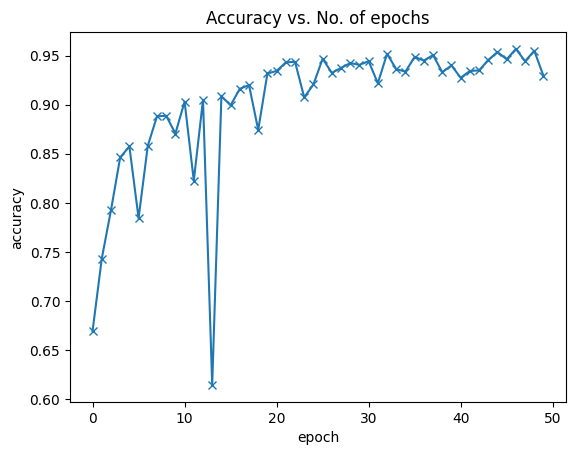

In [61]:
plot_accuracies(res2)

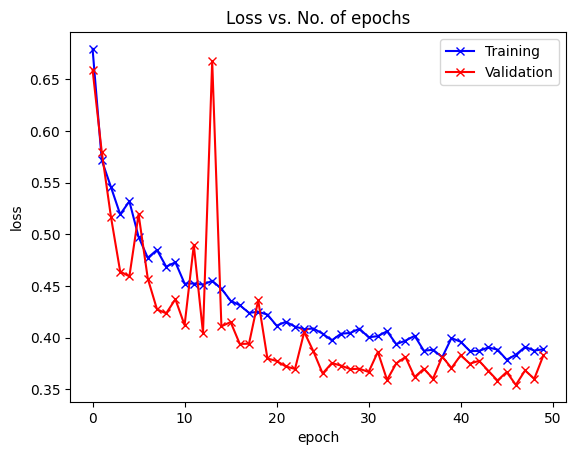

In [62]:
plot_losses(res2)

### Création de notre propre CNN

Augmentation des données

In [130]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation((30,70)),
    transforms.RandomCrop((25,50)),
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()
])

data_train = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\train_another',transform=transform)
data_val = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\validation_another',transform=transform)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32)

Structure du CNN : on essaie notamment d'ajouter un padding

In [155]:
class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(384, 512), 
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [156]:
model3 = Net()
lr = 0.0001
epochs = 50
max_steps_per_epoch = 100
opt_func = torch.optim.Adam
max_validation_step = 50

In [151]:
res3 = fit(epochs, lr, model3, train_loader, val_loader, opt_func, max_steps_per_epoch)

Epoch [0], train_loss: 0.6905, val_loss: 0.6920, val_acc: 0.5587
Epoch [1], train_loss: 0.6749, val_loss: 0.6611, val_acc: 0.6600
Epoch [2], train_loss: 0.6296, val_loss: 0.6291, val_acc: 0.6600
Epoch [3], train_loss: 0.5924, val_loss: 0.5694, val_acc: 0.7200
Epoch [4], train_loss: 0.5768, val_loss: 0.5105, val_acc: 0.7494
Epoch [5], train_loss: 0.5538, val_loss: 0.5854, val_acc: 0.6963
Epoch [6], train_loss: 0.5501, val_loss: 0.4680, val_acc: 0.7750
Epoch [7], train_loss: 0.5474, val_loss: 0.4724, val_acc: 0.7837
Epoch [8], train_loss: 0.5355, val_loss: 0.5633, val_acc: 0.6913
Epoch [9], train_loss: 0.5098, val_loss: 0.5526, val_acc: 0.7212
Epoch [10], train_loss: 0.5091, val_loss: 0.4575, val_acc: 0.7950
Epoch [11], train_loss: 0.5203, val_loss: 0.4487, val_acc: 0.8106
Epoch [12], train_loss: 0.4895, val_loss: 0.4119, val_acc: 0.8163
Epoch [13], train_loss: 0.4972, val_loss: 0.4689, val_acc: 0.7794
Epoch [14], train_loss: 0.4831, val_loss: 0.4851, val_acc: 0.7663
Epoch [15], train_lo

Augmentation des données : ajout de flou

In [162]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation((30,70)),
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    transforms.ToTensor()
])

data_train = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\train_another',transform=transform)
data_test = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\test_another',transform=transform)
data_val = datasets.ImageFolder(r'C:\Documents\travail\LYON2\M2\deep_learning\Post-hurricane\validation_another',transform=transform)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32)

Structure du CNN : on essaie notamment d'ajouter un padding

In [163]:
class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(10368, 512), 
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [165]:
model3 = Net()
lr = 0.0001
epochs = 50
max_steps_per_epoch = 100
opt_func = torch.optim.Adam
max_validation_step = 50

In [166]:
res3 = fit(epochs, lr, model3, train_loader, val_loader, opt_func, max_steps_per_epoch)

Epoch [0], train_loss: 0.6650, val_loss: 0.6198, val_acc: 0.6800
Epoch [1], train_loss: 0.5598, val_loss: 0.4542, val_acc: 0.8319
Epoch [2], train_loss: 0.4473, val_loss: 0.2938, val_acc: 0.8975
Epoch [3], train_loss: 0.3798, val_loss: 0.3004, val_acc: 0.8888
Epoch [4], train_loss: 0.3200, val_loss: 0.2648, val_acc: 0.9131
Epoch [5], train_loss: 0.2952, val_loss: 0.3282, val_acc: 0.8669
Epoch [6], train_loss: 0.2573, val_loss: 0.2042, val_acc: 0.9369
Epoch [7], train_loss: 0.2515, val_loss: 0.1507, val_acc: 0.9481
Epoch [8], train_loss: 0.2270, val_loss: 0.1340, val_acc: 0.9544
Epoch [9], train_loss: 0.2328, val_loss: 0.1442, val_acc: 0.9556
Epoch [10], train_loss: 0.2220, val_loss: 0.1457, val_acc: 0.9531
Epoch [11], train_loss: 0.1986, val_loss: 0.1150, val_acc: 0.9619
Epoch [12], train_loss: 0.1920, val_loss: 0.1859, val_acc: 0.9237
Epoch [13], train_loss: 0.1924, val_loss: 0.1256, val_acc: 0.9575
Epoch [14], train_loss: 0.1844, val_loss: 0.1337, val_acc: 0.9538
Epoch [15], train_lo

In [169]:
cnn3 = pd.DataFrame(res3)
cnn3.to_csv('cnn2.csv', sep='\t')

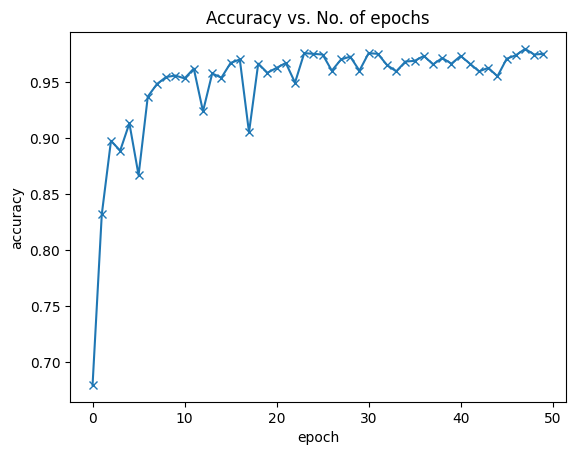

In [167]:
plot_accuracies(res3)

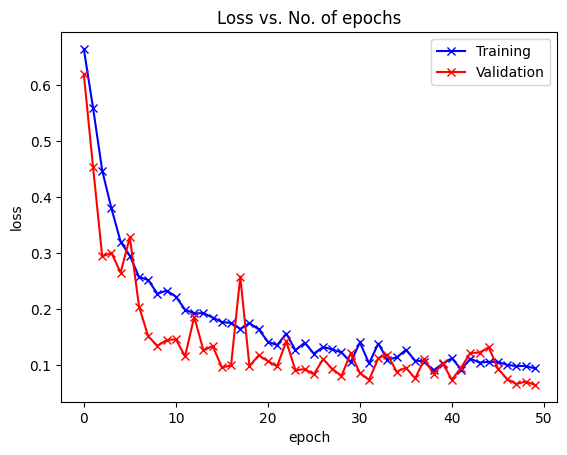

In [168]:
plot_losses(res3)